# PROJEKT EKSPERYMENTALNEJ SIECI Z HIPERZESPOLONĄ GŁOWICĄ
**Struktura:**
1. IMPORTY ŚRODOWISK
2. PRZYGOTOWANIE DANYCH
3. DEFINICJE FUNKCJI
4. EKSPERYMENTY ZASADNICZE (Exp1-Exp6)
5. TESTY STABILNOŚCI
6. RAPORTOWANIE WYNIKÓW


## 1. IMPORTY ŚRODOWISK


In [ ]:
# INSTALACJA ZEWNĘTRZNYCH BIBLIOTEK
!pip install git+https://github.com/rkycia/HypercomplexKeras.git -q

# BIBLIOTEKI STANDARDOWE
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SKLEARN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# TESTY STATYSTYCZNE
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

#TENSORFLOW / KERAS
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, MaxPooling1D,
    LSTM, Dense, Dropout, LeakyReLU, Activation,
    Attention, Add, LayerNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session

# HYPERCOMPLEX KERAS
from HypercomplexKeras.Hyperdense import HyperDense
from HypercomplexKeras import Algebra

#GOOGLE COLAB
from google.colab import drive
drive.mount('/content/drive')

# USTAWIENIA GLOBALNE
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

# Funkcja do ustawiania wszystkich seedów
def set_all_seeds(seed):
    """Ustawia wszystkie źródła losowości dla powtarzalności."""
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    try:
        tf.config.experimental.enable_op_determinism()
    except AttributeError:
        print("Uwaga: Twoja wersja TensorFlow jest za stara na pełny determinizm.")

    print(f"Ustawiono seed: {seed} z wymuszonym determinizmem operacji.")

set_all_seeds(1234)

print("Biblioteki załadowane pomyślnie.")




  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Mounted at /content/drive
Ustawiono seed: 1234 z wymuszonym determinizmem operacji.
Biblioteki załadowane pomyślnie.



## 2. PRZYGOTOWANIE DANYCH


In [ ]:
# 2.1 WCZYTANIE DANYCH
df = pd.read_csv('/content/drive/MyDrive/aapl_us_2025.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

print(f"Wczytano {len(df)} wierszy.")
print(f"Zakres dat: {df.index.min()} - {df.index.max()}")

# 2.2 ANALIZA BRAKÓW DANYCH
missing_report = df.isnull().sum()
if missing_report.sum() == 0:
    print("Brak pustych wartości. Zbiór kompletny.")
else:
    print("Puste wartości:", missing_report[missing_report > 0])

Wczytano 10171 wierszy.
Zakres dat: 1984-09-07 00:00:00 - 2025-01-17 00:00:00
Brak pustych wartości. Zbiór kompletny.


In [ ]:
# 2.3 TESTY STATYSTYCZNE (ADF, LJUNG-BOX)

def analyze_column_statistics(series, col_name):
    print(f"\nANALIZA: {col_name}")
    clean_series = series.dropna()

    # Test ADF (Stacjonarność)
    adf_res = adfuller(clean_series)
    print(f"  ADF: stat={adf_res[0]:.4f}, p={adf_res[1]:.4f}", end=" ")
    print("→ STACJONARNY" if adf_res[1] < 0.05 else "→ NIESTACJONARNY")

    # Test Ljunga-Boxa (Autokorelacja)
    lb_res = acorr_ljungbox(clean_series, lags=10, return_df=True)
    lb_p = lb_res['lb_pvalue'].values[0]
    print(f"  Ljung-Box: p={lb_p:.4f}", end=" ")
    print("→ AUTOKORELACJA" if lb_p < 0.05 else "→ BIAŁY SZUM")

# Analiza danych surowych
base_columns = ['Open', 'High', 'Low', 'Close']
print("ETAP 1: DANE SUROWE (CENY)")
for col in base_columns:
    analyze_column_statistics(df[col], col)

ETAP 1: DANE SUROWE (CENY)

ANALIZA: Open
  ADF: stat=3.8334, p=1.0000 → NIESTACJONARNY
  Ljung-Box: p=0.0000 → AUTOKORELACJA

ANALIZA: High
  ADF: stat=3.9435, p=1.0000 → NIESTACJONARNY
  Ljung-Box: p=0.0000 → AUTOKORELACJA

ANALIZA: Low
  ADF: stat=4.0042, p=1.0000 → NIESTACJONARNY
  Ljung-Box: p=0.0000 → AUTOKORELACJA

ANALIZA: Close
  ADF: stat=3.8294, p=1.0000 → NIESTACJONARNY
  Ljung-Box: p=0.0000 → AUTOKORELACJA


In [ ]:
# 2.4 TRANSFORMACJA LOG-ZWROTÓW
df_log = pd.DataFrame(index=df.index)
for col in base_columns:
    df_log[f'Log_{col}'] = np.log(df[col] / df[col].shift(1))

# Analiza log-zwrotów
log_columns = [f'Log_{c}' for c in base_columns]
print("ETAP 2: LOG-ZWROTY (PO TRANSFORMACJI)")
for col in log_columns:
    analyze_column_statistics(df_log[col], col)

ETAP 2: LOG-ZWROTY (PO TRANSFORMACJI)

ANALIZA: Log_Open
  ADF: stat=-21.4673, p=0.0000 → STACJONARNY
  Ljung-Box: p=0.0000 → AUTOKORELACJA

ANALIZA: Log_High
  ADF: stat=-16.1012, p=0.0000 → STACJONARNY
  Ljung-Box: p=0.0000 → AUTOKORELACJA

ANALIZA: Log_Low
  ADF: stat=-21.5111, p=0.0000 → STACJONARNY
  Ljung-Box: p=0.0000 → AUTOKORELACJA

ANALIZA: Log_Close
  ADF: stat=-25.7059, p=0.0000 → STACJONARNY
  Ljung-Box: p=0.7885 → BIAŁY SZUM


In [ ]:
# 2.5 WSKAŹNIKI TECHNICZNE
df_indicators = df.copy()

# RSI (14-dniowy)
delta = df_indicators['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df_indicators['Ind_RSI'] = 100 - (100 / (1 + rs))

# MACD
exp12 = df_indicators['Close'].ewm(span=12, adjust=False).mean()
exp26 = df_indicators['Close'].ewm(span=26, adjust=False).mean()
df_indicators['Ind_MACD'] = exp12 - exp26

# Log ATR (14-dniowy)
high_low = df_indicators['High'] - df_indicators['Low']
high_close = np.abs(df_indicators['High'] - df_indicators['Close'].shift())
low_close = np.abs(df_indicators['Low'] - df_indicators['Close'].shift())
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df_indicators['Ind_Log_ATR'] = np.log(tr.rolling(14).mean())

# ROC (10-dniowy)
df_indicators['Ind_ROC'] = df_indicators['Close'].pct_change(periods=10)

# 2.6 FINALNA RAMKA DANYCH
features_tech = ['Ind_RSI', 'Ind_MACD', 'Ind_Log_ATR', 'Ind_ROC']
df_final = df_log.join(df_indicators[features_tech], how='inner')
df_final.dropna(inplace=True)

# Definicja zestawów cech
FEATS_4 = ['Log_Open', 'Log_High', 'Log_Low', 'Log_Close']
FEATS_8 = ['Log_Open', 'Log_High', 'Log_Low', 'Log_Close',
           'Ind_RSI', 'Ind_MACD', 'Ind_Log_ATR', 'Ind_ROC']

print(f"\nDANE GOTOWE: {df_final.shape[0]} obserwacji, {df_final.shape[1]} cech")
print(f"Zestaw 4-cechowy: {FEATS_4}")
print(f"Zestaw 8-cechowy: {FEATS_8}")


DANE GOTOWE: 10158 obserwacji, 8 cech
Zestaw 4-cechowy: ['Log_Open', 'Log_High', 'Log_Low', 'Log_Close']
Zestaw 8-cechowy: ['Log_Open', 'Log_High', 'Log_Low', 'Log_Close', 'Ind_RSI', 'Ind_MACD', 'Ind_Log_ATR', 'Ind_ROC']


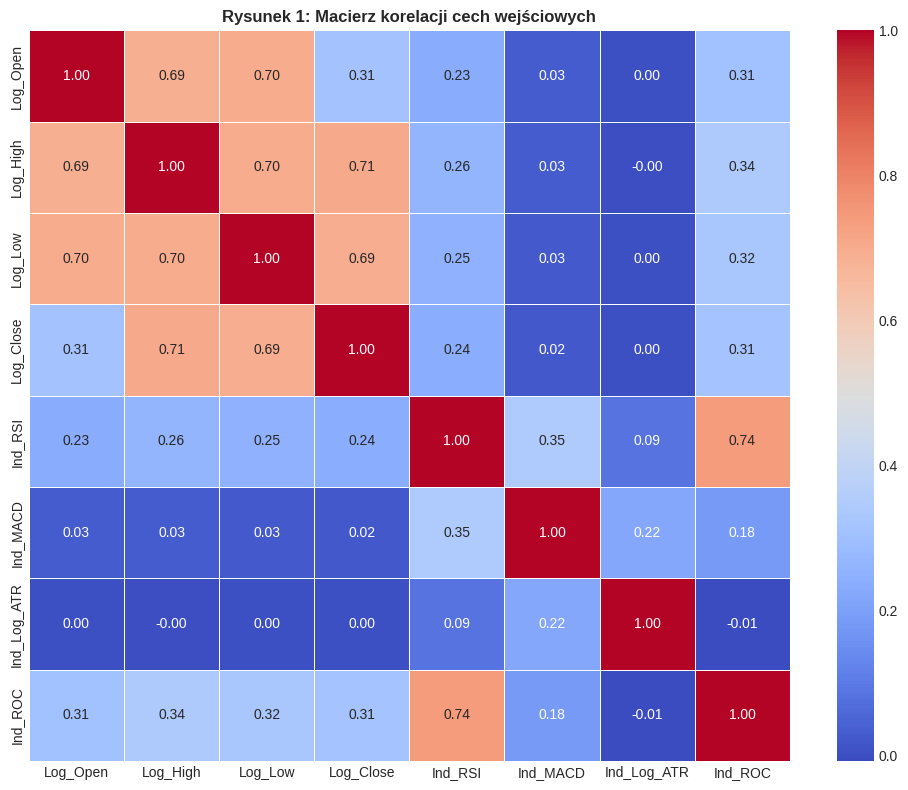

Zapisano: fig1_correlation_matrix.png


In [ ]:
# 2.7 MACIERZ KORELACJI (Rysunek 1)
plt.figure(figsize=(10, 8))
correlation_matrix = df_final[FEATS_8].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Rysunek 1: Macierz korelacji cech wejściowych', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('fig1_correlation_matrix.png', dpi=300)
plt.show()
print("Zapisano: fig1_correlation_matrix.png")


## 3. DEFINICJE FUNKCJI


In [ ]:
# PARAMETRY GLOBALNE
LOOKBACK = 60
HORIZONS = [5, 10]
N_SPLITS = 5
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.001
VAL_FRACTION = 0.2 # "wydział" walidacyjny ze zbioru treningowego

In [ ]:
def create_dataset(X, y, time_steps=LOOKBACK):
    """Tworzy sekwencje czasowe dla modelu LSTM."""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


def get_baselines_predictions(y_train_real, y_test_shape):
    """Generuje predykcje baseline (średnia historyczna, zero)."""
    mean_val = np.mean(y_train_real)
    base_mean = np.full(y_test_shape, mean_val)
    base_zero = np.zeros(y_test_shape)
    return base_zero, base_mean


def calculate_metrics(y_true, y_pred):
    """Oblicza metryki MAE i RMSE."""
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }

print("Funkcje pomocnicze zdefiniowane.")

Funkcje pomocnicze zdefiniowane.


In [ ]:
def create_financial_standard_model(input_dim, activation_type='tanh', lr=LEARNING_RATE):
    """
    Model CNN-LSTM-Attention z warstwą HyperDense.

    Architektura:
    1. Conv1D (wykrywanie formacji świecowych)
    2. LSTM (pamięć sekwencyjna)
    3. Attention + Skip Connection
    4. HyperDense (warstwa hiperkompleksowa)
    5. Dense output
    """
    inputs = Input(shape=(LOOKBACK, input_dim))

    # CNN
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # LSTM
    lstm_out = LSTM(64, return_sequences=True)(x)
    lstm_out = Dropout(0.2)(lstm_out)

    # Attention + Skip Connection
    attn_out = Attention()([lstm_out, lstm_out])
    x = Add()([lstm_out, attn_out])
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)

    # HyperComplex Head
    x = HyperDense(units=16)(x)
    if activation_type == 'tanh':
        x = Activation('tanh')(x)
    else:
        x = LeakyReLU(negative_slope=0.01)(x)
    x = Dropout(0.3)(x)

    # Output
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs, name="Financial_HyperComplex")
    model.compile(loss='huber', optimizer=Adam(learning_rate=lr), metrics=['mae'])

    return model

print("Model zdefiniowany.")

Model zdefiniowany.


In [ ]:
def run_experiment(feature_cols, df, target_col_name, activation, exp_name, h,
                   dane_do_wykresow=None):
    """
    Przeprowadza pojedynczy eksperyment z walidacją krzyżową TimeSeriesSplit.

    Args:
        feature_cols: lista kolumn cech
        df: ramka danych
        target_col_name: nazwa kolumny targetu
        activation: typ aktywacji ('tanh' lub 'leaky')
        exp_name: nazwa eksperymentu (np. 'Exp1_H5')
        h: horyzont predykcji
        dane_do_wykresow: słownik do zapisu predykcji (opcjonalnie)

    Returns:
        Lista wyników dla każdego foldu
    """
    data = df.dropna(subset=[target_col_name] + feature_cols).copy()
    X = data[feature_cols].values
    y = data[target_col_name].values
    input_dim = len(feature_cols)

    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    fold_results = []

    print(f"  {exp_name}", end="")

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        print(".", end="", flush=True)

        # Split
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Skalowanie
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_sc = scaler_X.fit_transform(X_train)
        y_train_sc = scaler_y.fit_transform(y_train.reshape(-1, 1))
        X_test_sc = scaler_X.transform(X_test)
        y_test_sc = scaler_y.transform(y_test.reshape(-1, 1))

        # Windowing
        X_train_seq, y_train_seq = create_dataset(X_train_sc, y_train_sc)
        X_test_seq, y_test_seq = create_dataset(X_test_sc, y_test_sc)

        if len(X_train_seq) == 0 or len(X_test_seq) == 0:
            continue

        # Wydzielenie walidacji ze zbioru treningowego
        n_train = len(X_train_seq)
        split_idx = int((1 - VAL_FRACTION) * n_train)
        X_tr, y_tr = X_train_seq[:split_idx], y_train_seq[:split_idx]
        X_val, y_val = X_train_seq[split_idx:], y_train_seq[split_idx:]

        # Wartości rzeczywiste (test pozostaje nietknięty)
        y_real = scaler_y.inverse_transform(y_test_seq)

        # Baseline
        base_zero, base_mean = get_baselines_predictions(y_train[LOOKBACK:], y_real.shape)

        # Model
        clear_session()
        model = create_financial_standard_model(input_dim=input_dim, activation_type=activation)

        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        )

        # Walidacja na wydzielonym zbiorze
        model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=EPOCHS, batch_size=BATCH_SIZE,
            verbose=0, shuffle=False, callbacks=[es]
        )

        # Predykcja na zbiorze testowym
        pred_sc = model.predict(X_test_seq, verbose=0)
        pred_real = scaler_y.inverse_transform(pred_sc)

        # Metryki
        m_model = calculate_metrics(y_real, pred_real)
        m_base_mean = calculate_metrics(y_real, base_mean)
        m_base_zero = calculate_metrics(y_real, base_zero)

        fold_results.append({
            'H': h, 'Fold': fold,
            'MAE': m_model['MAE'], 'RMSE': m_model['RMSE'],
            'Base_Mean_MAE': m_base_mean['MAE'], 'Base_Mean_RMSE': m_base_mean['RMSE'],
            'Base_Zero_MAE': m_base_zero['MAE'], 'Base_Zero_RMSE': m_base_zero['RMSE']
        })

        # Zapis do wykresów (ostatni fold)
        if fold == N_SPLITS and dane_do_wykresow is not None:
            dane_do_wykresow[(h, exp_name)] = pred_real.flatten()

    print(" [OK]")
    return fold_results

print("Funkcja eksperymentalna zdefiniowana (z poprawną walidacją).")

Funkcja eksperymentalna zdefiniowana (z poprawną walidacją).



## 4. EKSPERYMENTY ZASADNICZE

| ID | Zadanie | Cechy | Aktywacja | Target |
|----|---------|-------|-----------|--------|
| Exp1 | Regresja zwrotu | 4 | tanh | Return |
| Exp2 | Regresja zwrotu | 8 | tanh | Return |
| Exp3 | Regresja zwrotu | 8 | LeakyReLU | Return |
| Exp4 | Zmienność | 4 | tanh | Volatility |
| Exp5 | Zmienność | 8 | tanh | Volatility |
| Exp6 | Zmienność | 8 | LeakyReLU | Volatility |



In [ ]:
# KONFIGURACJA EKSPERYMENTÓW
EXPERIMENTS_CONFIG = [
    {'name': 'Exp1', 'desc': 'Reg Return (4f, tanh)',   'feats': FEATS_4, 'act': 'tanh',  'task': 'Return'},
    {'name': 'Exp2', 'desc': 'Reg Return (8f, tanh)',   'feats': FEATS_8, 'act': 'tanh',  'task': 'Return'},
    {'name': 'Exp3', 'desc': 'Reg Return (8f, Leaky)',  'feats': FEATS_8, 'act': 'leaky', 'task': 'Return'},
    {'name': 'Exp4', 'desc': 'Volatility (4f, tanh)',   'feats': FEATS_4, 'act': 'tanh',  'task': 'Volatility'},
    {'name': 'Exp5', 'desc': 'Volatility (8f, tanh)',   'feats': FEATS_8, 'act': 'tanh',  'task': 'Volatility'},
    {'name': 'Exp6', 'desc': 'Volatility (8f, Leaky)',  'feats': FEATS_8, 'act': 'leaky', 'task': 'Volatility'},
]

print(f"Zdefiniowano {len(EXPERIMENTS_CONFIG)} eksperymentów.")
print(f"Horyzonty: {HORIZONS}")

Zdefiniowano 6 eksperymentów.
Horyzonty: [5, 10]


In [ ]:
# URUCHOMIENIE EKSPERYMENTÓW ZASADNICZYCH
results_list = []
dane_do_wykresow = {}

print("ROZPOCZĘCIE EKSPERYMENTÓW ZASADNICZYCH")


for h in HORIZONS:
    print(f"\n>>> HORYZONT H={h}")

    # Obliczenie targetów
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=h)
    target_ret_col = f'Target_Ret_{h}'
    target_vol_col = f'Target_Vol_{h}'

    if target_ret_col not in df_final.columns:
        df_final[target_ret_col] = df_final['Log_Close'].rolling(window=indexer).sum()
    if target_vol_col not in df_final.columns:
        df_final[target_vol_col] = np.sqrt((df_final['Log_Close']**2).rolling(window=indexer).sum())

    dane_do_wykresow[(h, 'Real_Ret')] = df_final[target_ret_col].values
    dane_do_wykresow[(h, 'Real_Vol')] = df_final[target_vol_col].values

    # Wykonanie eksperymentów
    for cfg in EXPERIMENTS_CONFIG:
        target_col = target_ret_col if cfg['task'] == 'Return' else target_vol_col
        exp_full_name = f"{cfg['name']}_H{h}"

        res = run_experiment(
            feature_cols=cfg['feats'],
            df=df_final,
            target_col_name=target_col,
            activation=cfg['act'],
            exp_name=exp_full_name,
            h=h,
            dane_do_wykresow=dane_do_wykresow
        )

        for r in res:
            r['Config_Name'] = cfg['name']
            r['Description'] = cfg['desc']
            r['Task'] = cfg['task']

        results_list.extend(res)

print("EKSPERYMENTY ZASADNICZE ZAKOŃCZONE")

ROZPOCZĘCIE EKSPERYMENTÓW ZASADNICZYCH

>>> HORYZONT H=5
  Exp1_H5..... [OK]
  Exp2_H5..... [OK]
  Exp3_H5..... [OK]
  Exp4_H5..... [OK]
  Exp5_H5..... [OK]
  Exp6_H5..... [OK]

>>> HORYZONT H=10
  Exp1_H10..... [OK]
  Exp2_H10..... [OK]
  Exp3_H10..... [OK]
  Exp4_H10..... [OK]
  Exp5_H10..... [OK]
  Exp6_H10..... [OK]
EKSPERYMENTY ZASADNICZE ZAKOŃCZONE



## 5. TESTY STABILNOŚCI

**Cel:** Weryfikacja powtarzalności wyników przy różnych inicjalizacjach wag i stochastyce uczenia.

**Metodologia:**
- Wybrano jedną reprezentatywną konfigurację: **Exp5** (FEATS_8 + tanh + Target_Vol_10)
- N=5 powtórzeń z różnymi seedami (1234+i)
- Raportowane: średnia, odchylenie standardowe, min, max, rozstęp





In [ ]:
# KONFIGURACJA TESTU STABILNOŚCI
N_TRIALS = 5  # Liczba powtórzeń
STABILITY_CONFIG = {'name': 'Exp5', 'feats': FEATS_8, 'act': 'tanh'}  # Jedna konfiguracja
STABILITY_HORIZON = 10  # H=10
STABILITY_TARGET = 'Target_Vol_10'

# SPRAWDZENIE CZY TARGET ISTNIEJE
if STABILITY_TARGET not in df_final.columns:
    print(f"Tworzenie kolumny {STABILITY_TARGET}...")
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=STABILITY_HORIZON)
    df_final[STABILITY_TARGET] = np.sqrt(
        (df_final['Log_Close']**2).rolling(window=indexer).sum()
    )

print(f"Konfiguracja: {STABILITY_CONFIG['name']}")
print(f"Horyzont: H={STABILITY_HORIZON}")
print(f"Target: {STABILITY_TARGET}")
print(f"Liczba powtórzeń: {N_TRIALS}")

Konfiguracja: Exp5
Horyzont: H=10
Target: Target_Vol_10
Liczba powtórzeń: 5


In [ ]:
# URUCHOMIENIE TESTÓW STABILNOŚCI
results_stability = []

print(f"TESTY STABILNOŚCI - {N_TRIALS} POWTÓRZEŃ")
print("Badana jest stabilność względem losowej inicjalizacji wag")
print("oraz stochastyki uczenia (dropout, batch shuffling).")


for trial in range(1, N_TRIALS + 1):
    print(f"\nTRIAL {trial}/{N_TRIALS}")

    # PEŁNA KONTROLA SEEDÓW
    seed = 1234 + trial
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    clear_session()

    exp_name = f"{STABILITY_CONFIG['name']}_H{STABILITY_HORIZON}_T{trial}"

    res = run_experiment(
        feature_cols=STABILITY_CONFIG['feats'],
        df=df_final,
        target_col_name=STABILITY_TARGET,
        activation=STABILITY_CONFIG['act'],
        exp_name=exp_name,
        h=STABILITY_HORIZON,
        dane_do_wykresow=None
    )

    for r in res:
        r['Trial'] = trial
        r['Seed'] = seed
        r['Config_Name'] = STABILITY_CONFIG['name']

    results_stability.extend(res)


print("TESTY STABILNOŚCI ZAKOŃCZONE")


TESTY STABILNOŚCI - 5 POWTÓRZEŃ
Badana jest stabilność względem losowej inicjalizacji wag
oraz stochastyki uczenia (dropout, batch shuffling).

TRIAL 1/5
  Exp5_H10_T1..... [OK]

TRIAL 2/5
  Exp5_H10_T2..... [OK]

TRIAL 3/5
  Exp5_H10_T3..... [OK]

TRIAL 4/5
  Exp5_H10_T4..... [OK]

TRIAL 5/5
  Exp5_H10_T5..... [OK]
TESTY STABILNOŚCI ZAKOŃCZONE


In [ ]:
# TABELA 1: WYNIKI TESTÓW STABILNOŚCI
stability_df = pd.DataFrame(results_stability)

# Agregacja po próbach (średnia z foldów dla każdego trial)
trial_summary = stability_df.groupby('Trial').agg({
    'MAE': 'mean',
    'RMSE': 'mean',
    'Seed': 'first'
}).reset_index()
print("TABELA 1: WYNIKI TESTÓW STABILNOŚCI (Exp5, H=10, Vol)")

print("\nWyniki dla poszczególnych prób:")
print(trial_summary.to_string(index=False, formatters={
    'MAE': '{:.6f}'.format,
    'RMSE': '{:.6f}'.format
}))

# Statystyki opisowe
print("STATYSTYKI OPISOWE:")


stats = {
    'Metryka': ['MAE', 'RMSE'],
    'Średnia': [trial_summary['MAE'].mean(), trial_summary['RMSE'].mean()],
    'Std': [trial_summary['MAE'].std(), trial_summary['RMSE'].std()],
    'Min': [trial_summary['MAE'].min(), trial_summary['RMSE'].min()],
    'Max': [trial_summary['MAE'].max(), trial_summary['RMSE'].max()],
    'Rozstęp': [trial_summary['MAE'].max() - trial_summary['MAE'].min(),
                trial_summary['RMSE'].max() - trial_summary['RMSE'].min()]
}
stats_df = pd.DataFrame(stats)
print(stats_df.to_string(index=False, formatters={
    'Średnia': '{:.6f}'.format,
    'Std': '{:.6f}'.format,
    'Min': '{:.6f}'.format,
    'Max': '{:.6f}'.format,
    'Rozstęp': '{:.6f}'.format
}))

# Współczynnik zmienności (CV)
cv_mae = (trial_summary['MAE'].std() / trial_summary['MAE'].mean()) * 100
cv_rmse = (trial_summary['RMSE'].std() / trial_summary['RMSE'].mean()) * 100
print(f"\nWspółczynnik zmienności (CV):")
print(f"  MAE:  {cv_mae:.2f}%")
print(f"  RMSE: {cv_rmse:.2f}%")

TABELA 1: WYNIKI TESTÓW STABILNOŚCI (Exp5, H=10, Vol)

Wyniki dla poszczególnych prób:
 Trial      MAE     RMSE  Seed
     1 0.040951 0.054551  1235
     2 0.033824 0.046953  1236
     3 0.041817 0.055394  1237
     4 0.030287 0.043761  1238
     5 0.038905 0.052682  1239
STATYSTYKI OPISOWE:
Metryka  Średnia      Std      Min      Max  Rozstęp
    MAE 0.037157 0.004936 0.030287 0.041817 0.011530
   RMSE 0.050668 0.005074 0.043761 0.055394 0.011633

Współczynnik zmienności (CV):
  MAE:  13.28%
  RMSE: 10.01%


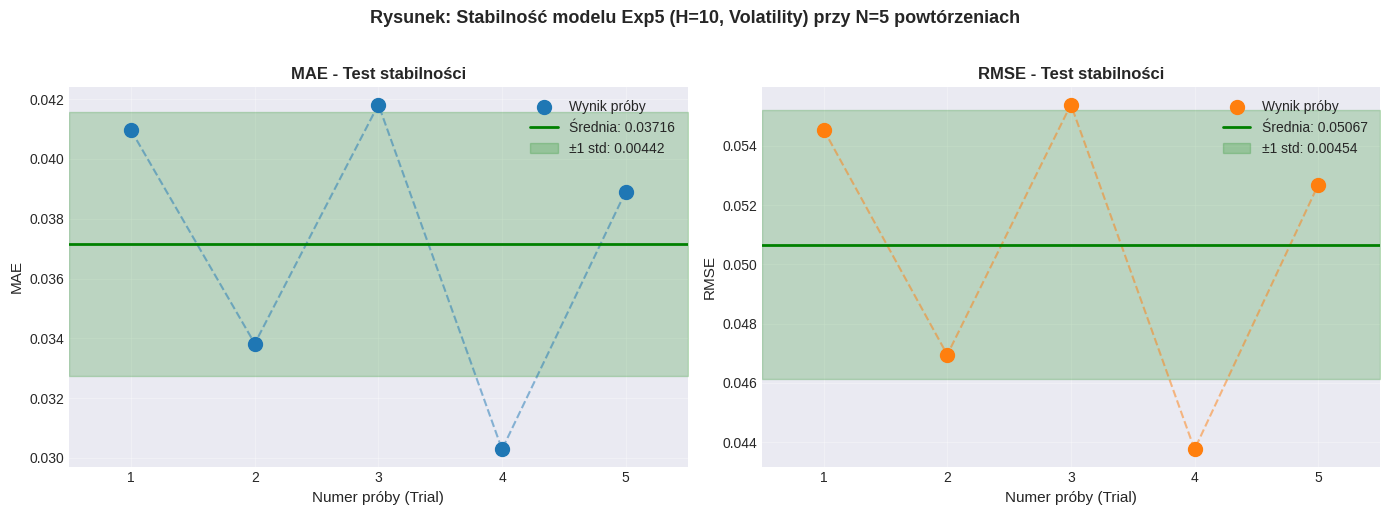

Zapisano: fig_stability_test.png


In [ ]:
# RYSUNEK: WYKRES STABILNOŚCI Z PASMEM ±1 STD
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics = ['MAE', 'RMSE']
colors = ['#1f77b4', '#ff7f0e']

for ax, metric, color in zip(axes, metrics, colors):
    values = trial_summary[metric].values
    trials = trial_summary['Trial'].values

    mean_val = values.mean()
    std_val = values.std()

    # Punkty dla każdej próby
    ax.scatter(trials, values, s=100, c=color, zorder=3, label='Wynik próby')
    ax.plot(trials, values, c=color, alpha=0.5, linestyle='--')

    # Linia średniej
    ax.axhline(mean_val, color='green', linewidth=2, label=f'Średnia: {mean_val:.5f}')

    # Pasmo ±1 std
    ax.fill_between([0.5, N_TRIALS + 0.5],
                    mean_val - std_val, mean_val + std_val,
                    color='green', alpha=0.2, label=f'±1 std: {std_val:.5f}')

    ax.set_xlabel('Numer próby (Trial)', fontsize=11)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} - Test stabilności', fontsize=12, fontweight='bold')
    ax.set_xticks(trials)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0.5, N_TRIALS + 0.5)

plt.suptitle('Rysunek: Stabilność modelu Exp5 (H=10, Volatility) przy N=5 powtórzeniach',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig_stability_test.png', dpi=300, bbox_inches='tight')
plt.show()
print("Zapisano: fig_stability_test.png")


## 6. RAPORTOWANIE WYNIKÓW


In [ ]:
# TABELA 2: PODSUMOWANIE EKSPERYMENTÓW ZASADNICZYCH
final_df = pd.DataFrame(results_list)

summary = final_df.groupby(['Task', 'H', 'Description', 'Config_Name'])[[
    'MAE', 'RMSE', 'Base_Mean_RMSE', 'Base_Mean_MAE'
]].mean().reset_index()

summary['RMSE_Improvement_%'] = ((summary['Base_Mean_RMSE'] - summary['RMSE']) / summary['Base_Mean_RMSE']) * 100
summary['MAE_Improvement_%'] = ((summary['Base_Mean_MAE'] - summary['MAE']) / summary['Base_Mean_MAE']) * 100
summary_sorted = summary.sort_values(by=['Task', 'H', 'RMSE'], ascending=[True, True, True])

print("TABELA 2: PODSUMOWANIE EKSPERYMENTÓW ZASADNICZYCH")

for task in summary_sorted['Task'].unique():
    print(f"\n>>> ZADANIE: {task.upper()}")
    cols = ['H', 'Config_Name', 'Description',
            'MAE', 'Base_Mean_MAE', 'MAE_Improvement_%',
            'RMSE', 'Base_Mean_RMSE', 'RMSE_Improvement_%']

    subset = summary_sorted[summary_sorted['Task'] == task][cols]
    print(subset.to_string(index=False, formatters={
        'MAE': '{:.5f}'.format,
        'Base_Mean_MAE': '{:.5f}'.format,
        'MAE_Improvement_%': '{:+.2f}%'.format,
        'RMSE': '{:.5f}'.format,
        'Base_Mean_RMSE': '{:.5f}'.format,
        'RMSE_Improvement_%': '{:+.2f}%'.format
    }))

TABELA 2: PODSUMOWANIE EKSPERYMENTÓW ZASADNICZYCH

>>> ZADANIE: RETURN
 H Config_Name            Description     MAE Base_Mean_MAE MAE_Improvement_%    RMSE Base_Mean_RMSE RMSE_Improvement_%
 5        Exp2  Reg Return (8f, tanh) 0.05152       0.04128           -24.82% 0.06692        0.05695            -17.51%
 5        Exp1  Reg Return (4f, tanh) 0.05097       0.04128           -23.47% 0.06728        0.05695            -18.13%
 5        Exp3 Reg Return (8f, Leaky) 0.05285       0.04128           -28.04% 0.06883        0.05695            -20.86%
10        Exp3 Reg Return (8f, Leaky) 0.07268       0.06028           -20.57% 0.09515        0.08165            -16.54%
10        Exp2  Reg Return (8f, tanh) 0.07779       0.06028           -29.05% 0.09843        0.08165            -20.55%
10        Exp1  Reg Return (4f, tanh) 0.08109       0.06028           -34.51% 0.10404        0.08165            -27.43%

>>> ZADANIE: VOLATILITY
 H Config_Name            Description     MAE Base_Mean_MAE MAE_

In [ ]:
# WYKRESY: FUNKCJE GENERUJĄCE

EXP_DESCRIPTIONS = {
    'Exp1': 'Reg. Return (4 feat, tanh)',
    'Exp2': 'Reg. Return (8 feat, tanh)',
    'Exp3': 'Reg. Return (8 feat, Leaky)',
    'Exp4': 'Vol. (4 feat, tanh)',
    'Exp5': 'Vol. (8 feat, tanh)',
    'Exp6': 'Vol. (8 feat, Leaky)'
}

def plot_predictions_comparison(h, exp_ids, title, figure_num, real_key='Real'):
    """
    Generuje wykres porównawczy predykcji.
    Argument real_key pozwala wskazać inny klucz dla danych rzeczywistych (np. dla zmienności).
    """
    plt.figure(figsize=(15, 6))

    # Sprawdzamy czy podany klucz (np. 'Real_Ret' lub 'Real_Vol') istnieje w danych
    if (h, real_key) not in dane_do_wykresow:
        print(f"Brak danych '{real_key}' dla H={h}. Dostępne klucze: {list(dane_do_wykresow.keys())}")
        return

    y_real = dane_do_wykresow[(h, real_key)]
    limit = min(150, len(y_real))
    range_idx = range(len(y_real) - limit, len(y_real))

    plt.plot(range_idx, y_real[-limit:], label='Rzeczywiste',
             color='gray', linewidth=2, alpha=0.6)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    line_styles = ['-', '--', '-.']

    for i, exp_id in enumerate(exp_ids):
        full_key = f"{exp_id}_H{h}"
        # Szukamy predykcji eksperymentu
        if (h, full_key) in dane_do_wykresow:
            y_pred = dane_do_wykresow[(h, full_key)]
            label = EXP_DESCRIPTIONS.get(exp_id, exp_id)
            plt.plot(range_idx, y_pred[-limit:], label=label,
                     color=colors[i % len(colors)],
                     linestyle=line_styles[i % len(line_styles)],
                     linewidth=1.5)

    plt.axhline(0, color='red', linewidth=1, linestyle=':', alpha=0.5)
    plt.title(f'Rysunek {figure_num}: H={h} - {title}', fontsize=12, fontweight='bold')
    plt.xlabel('Indeks czasowy')
    plt.xlabel('Indeks czasowy')

    if "Zmienność" in title:
        plt.ylabel('Zmienność (odchylenie std.)')
    else:
        plt.ylabel('Log-stopa zwrotu (skumulowana)')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    # plt.savefig(f'fig{figure_num}_h{h}_{title.replace(" ", "_").lower()}.png', dpi=300) # Opcjonalnie
    plt.show()



def plot_rmse_benchmark(summary_df, figure_num):
    """Generuje wykres słupkowy RMSE vs Benchmark."""
    for task in summary_df['Task'].unique():
        task_data = summary_df[summary_df['Task'] == task]
        if task_data.empty:
            continue

        g = sns.catplot(
            data=task_data, kind="bar", x="Description", y="RMSE", hue="H",
            palette="viridis", height=5, aspect=2.0, legend=False
        )
        ax = g.ax

        base_h5 = task_data[task_data['H'] == 5]['Base_Mean_RMSE'].mean()
        base_h10 = task_data[task_data['H'] == 10]['Base_Mean_RMSE'].mean()

        if not pd.isna(base_h5):
            ax.axhline(base_h5, color='purple', linestyle='--', linewidth=2, label='Benchmark H=5')
        if not pd.isna(base_h10):
            ax.axhline(base_h10, color='orange', linestyle='--', linewidth=2, label='Benchmark H=10')

        plt.title(f"Rysunek {figure_num}: RMSE vs Benchmark - {task.upper()}",
                  fontsize=12, fontweight='bold')
        plt.ylabel("RMSE")
        plt.xlabel("")
        plt.xticks(rotation=30, ha='right')
        plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
        plt.tight_layout()
        plt.savefig(f'fig{figure_num}_rmse_{task.lower()}.png', dpi=300)
        plt.show()
        figure_num += 1

print("Funkcje wizualizacji zdefiniowane.")

Funkcje wizualizacji zdefiniowane.



Generowanie wykresów...


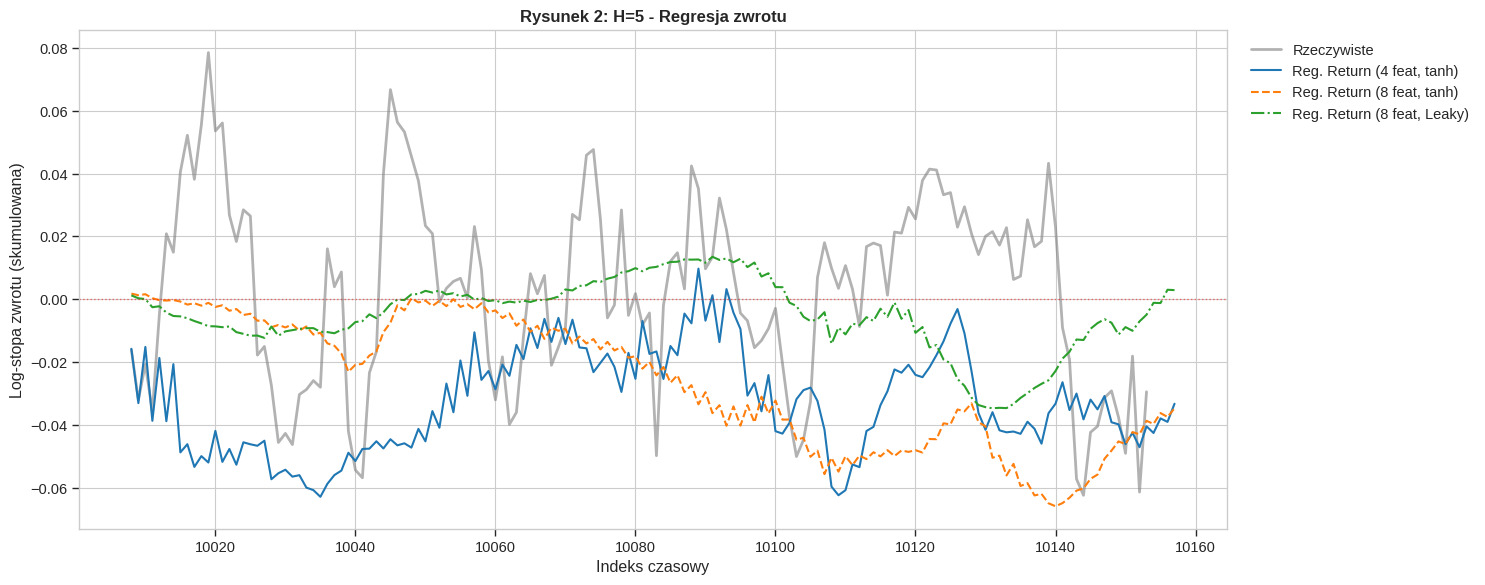

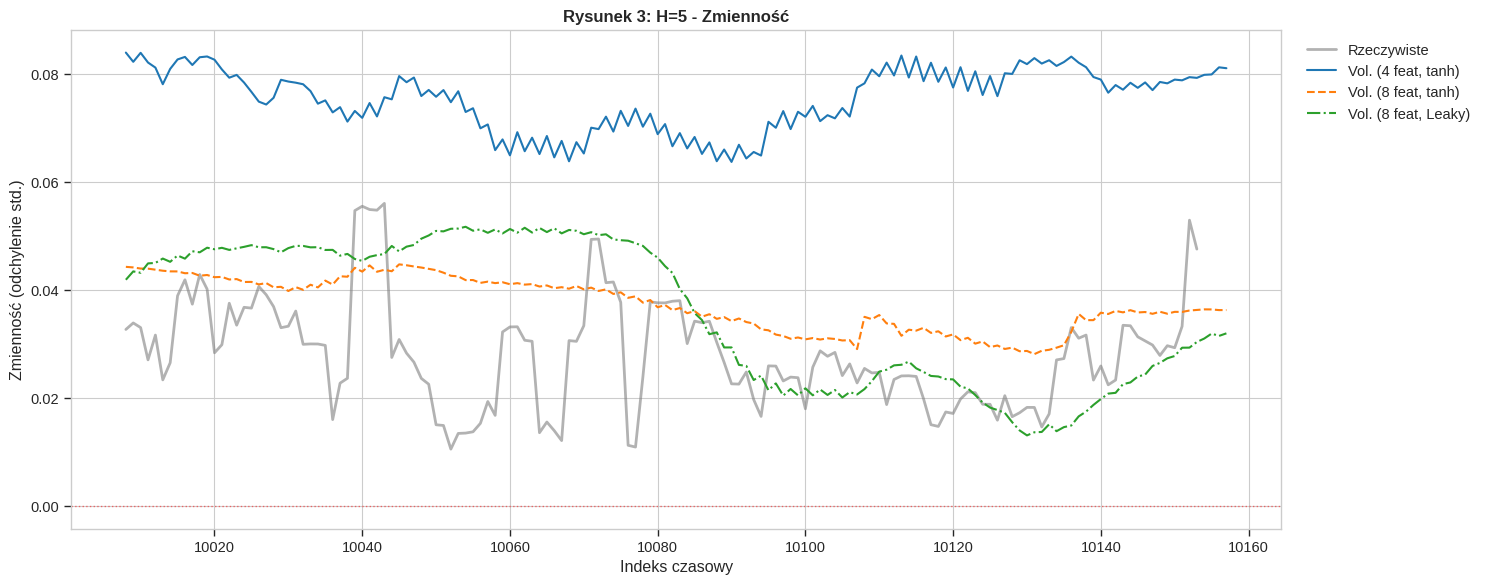

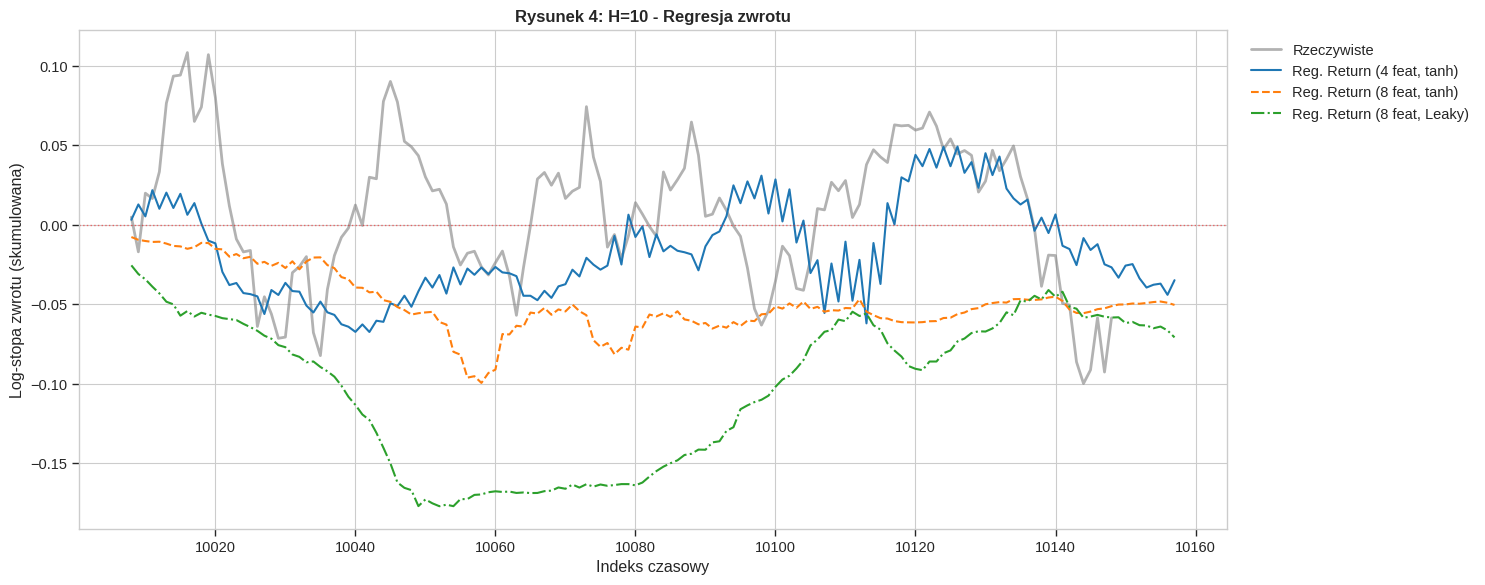

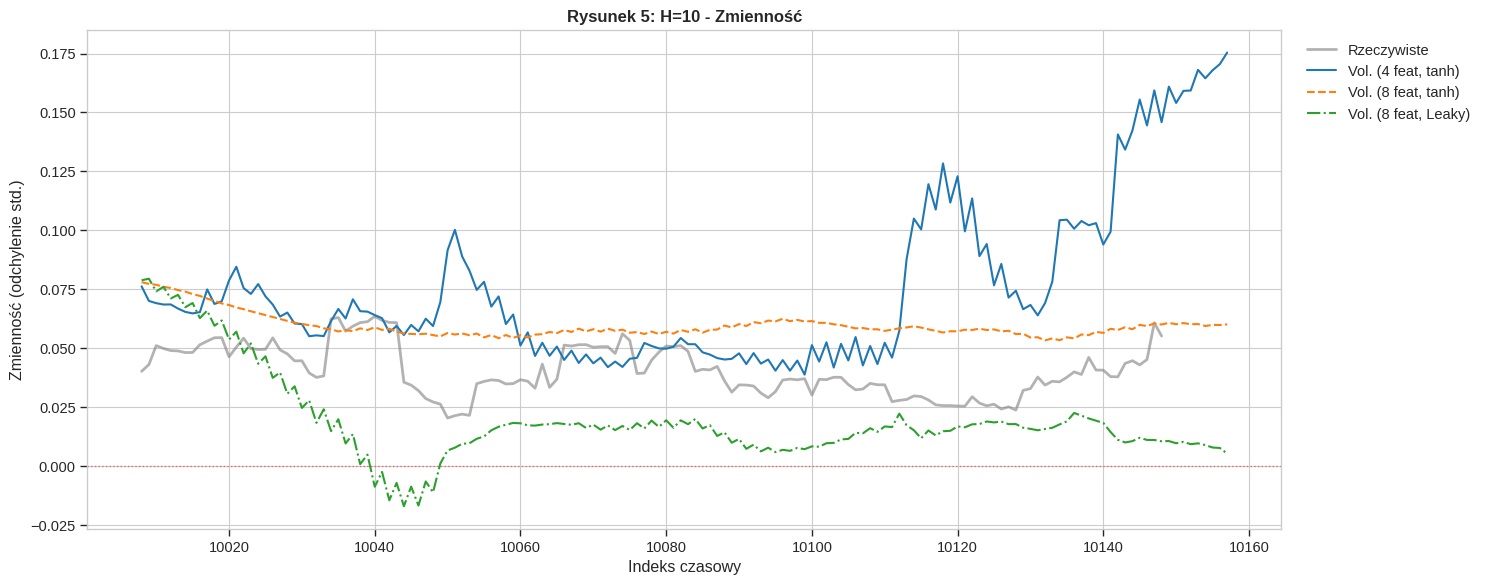

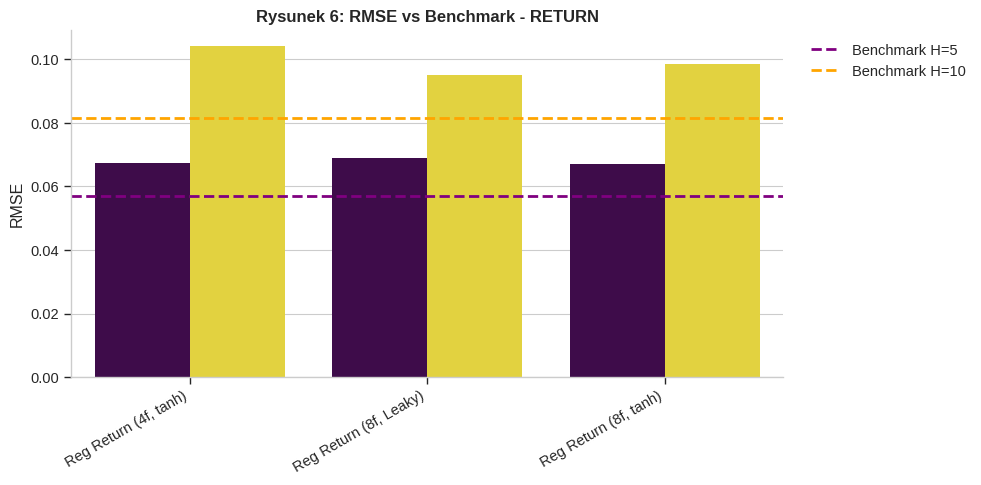

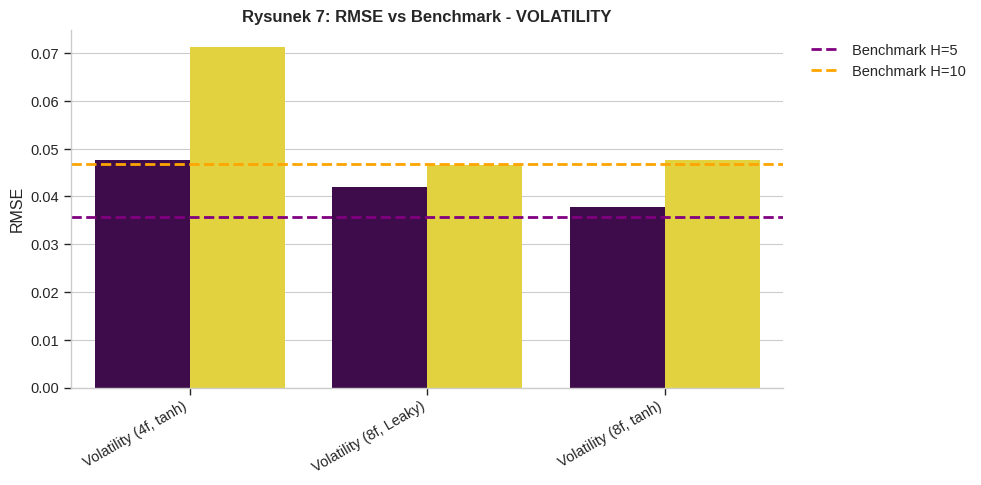


Wszystkie wykresy wygenerowane.


In [ ]:
#  GENEROWANIE WYKRESÓW
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)

print("\nGenerowanie wykresów...")

fig_num = 2

# Wykresy predykcji
for h in HORIZONS:
    # Rysunek: Regresja zwrotu
    plot_predictions_comparison(h, ['Exp1', 'Exp2', 'Exp3'], 'Regresja zwrotu', fig_num, real_key='Real_Ret')
    fig_num += 1

    # Rysunek: Zmienność
    plot_predictions_comparison(h, ['Exp4', 'Exp5', 'Exp6'], 'Zmienność', fig_num, real_key='Real_Vol' )
    fig_num += 1

# Wykresy słupkowe RMSE
plot_rmse_benchmark(summary, fig_num)

print("\nWszystkie wykresy wygenerowane.")